In [ ]:
!pip install -q transformers datasets torch torchvision albumentations matplotlib load_dotenv
!pip install -q -U "huggingface_hub[cli]"


In [1]:
from dotenv import load_dotenv
import os
# Load environment variables from a file named '.env' in the same directory
load_dotenv()

HUGGINGFACE_TOKEN = os.environ['HUGGINGFACE_TOKEN']
!huggingface-cli login --token $HUGGINGFACE_TOKEN --add-to-git-credential


KeyError: 'HUGGINGFACE_TOKEN'

In [ ]:
# !huggingface-cli download doc2txt/tbl-unet --local-dir tbl-unet

# init

In [2]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import torch.nn as nn
import torchvision
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torchvision.transforms.functional as TF
import torch.optim as optim
from tqdm import tqdm
import time

BASE_PATH = "../pdfBLines/tblDS/"
# BASE_PATH = "/home/ubuntu/work/carvana/dataset/"
CHECKPOINT_PATH = "./tbl-unet/tbl_dice1.00.pth.tar"


# Hyperparameters etc.
LEARNING_RATE = 3e-4 # Andrej Karpathy LR
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print("DEVICE", DEVICE)
BATCH_SIZE = 4
NUM_EPOCHS = 100
NUM_WORKERS = 2
IMAGE_HEIGHT = 512 
IMAGE_WIDTH = 512  
PIN_MEMORY = True
LOAD_MODEL = False
WEIGHT_DECAY = 0 # 1e-4


/Users/eliaweiss/opt/anaconda3/envs/LayoutLMv3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [3]:

class TblDataset(Dataset):
    def __init__(self, root_dir, transform=None):     
        self.root_dir = root_dir
        self.transform = transform
        
        self.images = os.listdir(self.root_dir)    
        self.images = list(filter(lambda x: "_src.jpg" in x, self.images))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.images[index])
        mask_path = os.path.join(self.root_dir, self.images[index].replace("_src.jpg", "_mask.png"))
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        mask.resize(image.size)
        image = np.array(image, dtype=np.float32)
        mask = np.array(mask, dtype=np.float32)
        mask[mask != 255] = 0
        mask[mask == 255] = 1.0
        
        image1,mask1 = image,mask
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image1 = augmentations['image']
            # assert image1.shape == image.shape, f"{ image1.shape},  {image.shape}"
            mask1 = augmentations['mask']
        
            
        return image1,mask1
        

In [5]:
root_dir=os.path.join(BASE_PATH,"train")
images = os.listdir(root_dir)   
images1 = list(filter(lambda x: "_src.jpg" in x, images))
len(images1)

1114

In [6]:
train_transform = A.Compose(
    [
        A. Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A. Rotate(limit=2.5, p=0.5),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ],
)
val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ],
)


In [8]:
UnetDataset = TblDataset
train_ds = UnetDataset(
    root_dir=os.path.join(BASE_PATH,"train"),
    transform=train_transform,
)
print(os.path.join(BASE_PATH,"train"))
train_loaders = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    # num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)
print(len(train_ds))
# val_ds = UnetDataset(
#     root_dir=os.path.join(BASE_PATH,"valid"),

#     transform=val_transform,
# )
# val_loaders = DataLoader(
#     val_ds,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKERS,
#     pin_memory=PIN_MEMORY,
#     shuffle=False,
# )
for batch in train_loaders:
    images, masks = batch
    break
print("images.shape", images.shape)
print("masks.shape", masks.shape)
data, targets = next(iter(train_loaders))
print ("data.dtype", data.dtype)
print ("targets.dtype", targets.dtype)

../pdfBLines/tblDS/train
1114
images.shape torch.Size([4, 1, 512, 512])
masks.shape torch.Size([4, 512, 512])
data.dtype torch.float32
targets.dtype torch.float32


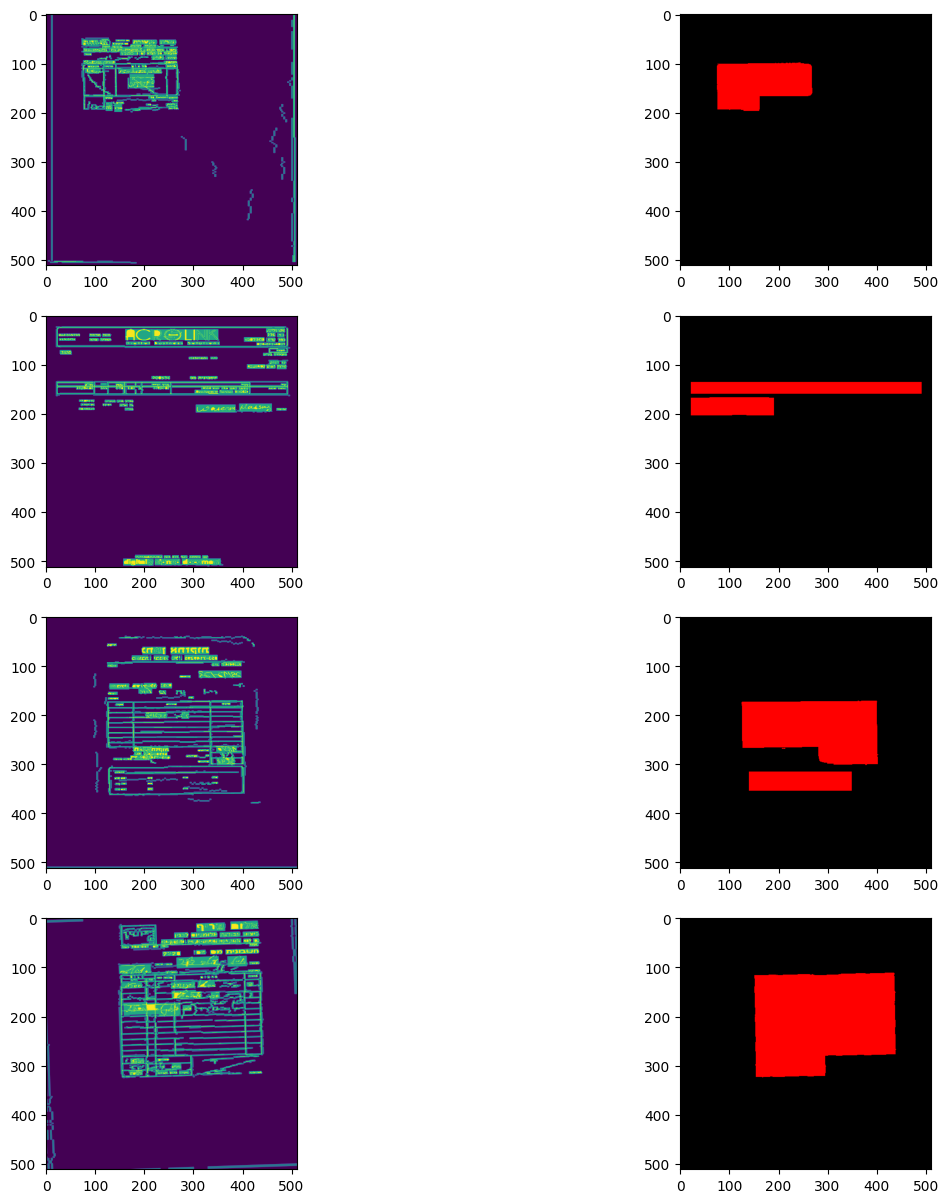

In [9]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

for batch in train_loaders:
    images, masks = batch
    break

n_plots = BATCH_SIZE
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)

for i in range(n_plots):
    image =images[i,:,:].permute(1, 2, 0)
    axarr[i,0].imshow(image)
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))

# Unet model

In [18]:
from torch import nn
from torch import cat
import numpy as np
# import cfg



class LFUNet(nn.Module):
    def __init__(self,in_channels=1, num_class=1):
        super().__init__()

        n = 8
        g = 8
        # x0.0 => out chanel = 8
        self.stage00 = nn.Sequential(
            nn.Conv2d(  in_channels,  n, kernel_size=3, stride=1, padding=1, groups=1), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1, groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x1.0 => out chanel = 8*2 = 16
        self.stage10 = nn.Sequential(
            nn.Conv2d(  n, 2*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(2*n), nn.ReLU(inplace=True),
            nn.Conv2d(2*n, 2*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(2*n), nn.ReLU(inplace=True),
        ) 
        # x2.0 => out chanel = 8*4 = 32
        self.stage20 = nn.Sequential(
            nn.Conv2d(2*n, 4*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(4*n), nn.ReLU(inplace=True),
            nn.Conv2d(4*n, 4*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(4*n), nn.ReLU(inplace=True),
        )
        # x3.0 => out chanel = 8*8 = 64
        self.stage30 = nn.Sequential(
            nn.Conv2d(4*n, 8*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(8*n), nn.ReLU(inplace=True),
            nn.Conv2d(8*n, 8*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(8*n), nn.ReLU(inplace=True),
        )
        # x4.0 => out chanel = 8*16 = 128
        self.stage40 = nn.Sequential(
            nn.Conv2d( 8*n, 16*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(16*n), nn.ReLU(inplace=True),
            nn.Conv2d(16*n, 16*n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(16*n), nn.ReLU(inplace=True),
        )

        # x0.1 
        self.stage01 = nn.Sequential(
            nn.Conv2d(2*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x1.1
        self.stage11 = nn.Sequential(
            nn.Conv2d(3*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x0.2
        self.stage02 = nn.Sequential(
            nn.Conv2d(4*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x2.1
        self.stage21 = nn.Sequential(
            nn.Conv2d(4*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x1.2
        self.stage12 = nn.Sequential(
            nn.Conv2d(5*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x0.3
        self.stage03 = nn.Sequential(
            nn.Conv2d(6*n,   n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,   n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x3.1
        self.stage31 = nn.Sequential(
            nn.Conv2d(5*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x2.2
        self.stage22 = nn.Sequential(
            nn.Conv2d(6*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x1.3
        self.stage13 = nn.Sequential(
            nn.Conv2d(7*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )
        # x0.4
        self.stage04 = nn.Sequential(
            nn.Conv2d(8*n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
            nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g), nn.BatchNorm2d(  n), nn.ReLU(inplace=True),
        )


        # trans
        self.stage0p = nn.Sequential(nn.Conv2d(  n,  n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage1p = nn.Sequential(nn.Conv2d(2*n,  n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage2p = nn.Sequential(nn.Conv2d(4*n,  n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage3p = nn.Sequential(nn.Conv2d(8*n,  n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage4p = nn.Sequential(nn.Conv2d(16*n, n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stagep = self.stage0p

        self.stage0zp = nn.Sequential(nn.Conv2d(n, n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage1zp = nn.Sequential(nn.Conv2d(2 * n, n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage2zp = nn.Sequential(nn.Conv2d(4 * n, n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage3zp = nn.Sequential(nn.Conv2d(8 * n, n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stage4zp = nn.Sequential(nn.Conv2d(16 * n, n, kernel_size=3, stride=1, padding=1,groups=g))
        self.stagezp = self.stage0zp

        # down-sampling
        self.stage2d = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage2zd = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2))
        self.stage4zd = nn.Sequential(nn.MaxPool2d(kernel_size=4, stride=4))
        self.stage8zd = nn.Sequential(nn.MaxPool2d(kernel_size=8, stride=8))

        # up-sampling
        self.stage2u = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True))
        self.stage4u = nn.Sequential(nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True))
        self.stage8u = nn.Sequential(nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True))
        self.stage16u = nn.Sequential(nn.Upsample(scale_factor=16, mode='bilinear', align_corners=True))

        # output
        self.stageout = nn.Sequential(
            nn.Conv2d(  n, num_class, 1 ,groups=1)
        )


    def forward(self, x):
        s00 = self.stage00(x) # out chanel = 8
        s10 = self.stage10(self.stage2d(s00)) # out chanel = 16
        s01 = self.stage01(cat([self.stage0p(s00), # out chanel = 8
                                self.stage1p(self.stage2u(s10))], 1))

        s20 = self.stage20(self.stage2d(s10))
        s11 = self.stage11(cat([self.stage0zp(self.stage2zd(s00)),
                                self.stage1p(s10),
                                self.stage2p(self.stage2u(s20))], 1))
        s02 = self.stage02(cat([self.stage0p(s00), self.stagezp(s01),
                                self.stage2zp(self.stage4u(s20)), self.stagep(self.stage2u(s11))], 1))

        s30 = self.stage30(self.stage2d(s20))
        s21 = self.stage21(cat([self.stage0zp(self.stage4zd(s00)), self.stage1zp(self.stage2zd(s10)),
                                self.stage2p(s20),
                                self.stage3p(self.stage2u(s30))], 1))
        s12 = self.stage12(cat([self.stage0zp(self.stage2zd(s00)),
                                self.stage1p(s10), self.stagezp(s11),
                                self.stage3zp(self.stage4u(s30)), self.stagep(self.stage2u(s21))], 1))
        s03 = self.stage03(
            cat([self.stage0p(s00), self.stagezp(s01), self.stagezp(s02),
                 self.stage3zp(self.stage8u(s30)), self.stagezp(self.stage4u(s21)), self.stagep(self.stage2u(s12))], 1))

        s40 = self.stage40(self.stage2d(s30))
        s31 = self.stage31(
            cat([self.stage0zp(self.stage8zd(s00)), self.stage1zp(self.stage4zd(s10)),
                 self.stage2zp(self.stage2zd(s20)),
                 self.stage3p(s30),
                 self.stage4p(self.stage2u(s40))], 1))
        s22 = self.stage22(cat([self.stage0zp(self.stage4zd(s00)), self.stage1zp(self.stage2zd(s10)),
                                self.stage2p(s20), self.stagezp(s21),
                                self.stage4zp(self.stage4u(s40)), self.stagep(self.stage2u(s31))], 1))
        s13 = self.stage13(
            cat([self.stage0zp(self.stage2zd(s00)),
                 self.stage1p(s10), self.stagezp(s11), self.stagezp(s12),
                 self.stage4zp(self.stage8u(s40)), self.stagezp(self.stage4u(s31)), self.stagep(self.stage2u(s22))], 1))
        s04 = self.stage04(
            cat([self.stage0p(s00), self.stagezp(s01), self.stagezp(s02), self.stagezp(s03),
                 self.stage4zp(self.stage16u(s40)), self.stagezp(self.stage8u(s31)),
                 self.stagezp(self.stage4u(s22)), self.stagep(self.stage2u(s13))], 1))

        out1 = self.stageout(s01)
        out2 = self.stageout(s02)
        out3 = self.stageout(s03)
        out4 = self.stageout(s04)
        # out = out1
        # out = (out1 + out2) / 2
        # out = (out1 + out2 + out3) / 3
        out = (out1 + out2 + out3 + out4) / 4

        return out

# Utils

In [19]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint",filename)
    torch.save(state, filename)

def check_accuracy(loader, model, device="cuda"):
    print("Checking accuracy")
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
            acc = (preds == y).sum()
            numElem = torch.numel(preds)
            # print(idx, acc/numElem)
            
            num_correct += acc
            num_pixels += numElem
            dice_score += (2*(preds*y).sum())/(
                (preds+y).sum() + 1e-8
            )

        print(
            f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
        )

        dice = dice_score/len(loader)
        print(f"Dice score: {dice}")

        model.train()
    return dice


def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    print("Saving predictions")
    start = time.time()
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, os.path.join(folder,f"pred_{idx}.png")
        )
        torchvision.utils.save_image(y.unsqueeze(1), 
                                    os.path.join(folder,f"correct_{idx}.png")
                                     )
    print(f"Saved predictions in {time.time()-start:.2f} seconds")
    model.train()


# Train

In [20]:
model = LFUNet(in_channels=1).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
optimizer = optim.AdamW(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

In [9]:
# load_checkpoint(
#     CHECKPOINT_PATH, model, optimizer, LEARNING_RATE
# )

=> Loading checkpoint


In [21]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    losses = []
    for batch_idx, (data, targets) in enumerate(loop):
    # for i in range(10):
    #     data, targets = next(iter(loader))
        
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        losses.append(loss.item())
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # print("loss", loss.item())

        # update tqdm
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)

In [22]:
# pos_weight = torch.ones([224]).to(DEVICE)
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = DiceLoss()

scaler = torch.cuda.amp.grad_scaler.GradScaler()
for epoch in range(NUM_EPOCHS):
    print("epoch", epoch)
    train_fn(train_loaders, model, optimizer, loss_fn, scaler)





    # print some example to folder
    if epoch % 10 == 0 and epoch>0:
        # save model
        check_point = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        # dice_score =check_accuracy(val_loaders, model, device=DEVICE)        
        # save_checkpoint(check_point, os.path.join(CHECKPOINT_PATH,f"blines_dice{dice_score}.pth.tar"))        
        # save_predictions_as_imgs(
        #     val_loaders, model, folder="save_images/", device=DEVICE
        # )


/Users/eliaweiss/opt/anaconda3/envs/LayoutLMv3/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch 0


  0%|          | 0/279 [00:00<?, ?it/s]/Users/eliaweiss/opt/anaconda3/envs/LayoutLMv3/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  0%|          | 1/279 [00:18<1:25:21, 18.42s/it, loss=0.799]


KeyboardInterrupt: 

In [ ]:
# dice_score =check_accuracy(val_loaders, model, device=DEVICE)        
save_checkpoint(check_point, CHECKPOINT_PATH)        
# save_checkpoint(check_point, os.path.join(CHECKPOINT_PATH,f"blines_dice{dice_score:.2F}.pth.tar"))        
COMMIT_MSG = f"from scrach IMAGE_HEIGHT {IMAGE_HEIGHT} BATCH_SIZE {BATCH_SIZE} epoch {epoch} loss 0.002 Transform rotate 2.5 only line tbls"


In [ ]:
!echo "$COMMIT_MSG"

In [ ]:
!huggingface-cli upload doc2txt/tbl-unet2 ./tbl-unet . --commit-message="$COMMIT_MSG"

In [ ]:
# model = model.half()

 # view results

In [10]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}
def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8).squeeze())

In [12]:

for idx, (pixel_values,masks) in enumerate(train_loaders):
# for idx, (pixel_values,masks) in enumerate(val_loaders):
    pixel_values = pixel_values.to(DEVICE)
    # pixel_values = pixel_values.half()
    print(idx, pixel_values.shape)
    preds = torch.sigmoid(model(pixel_values))
    print(idx, preds.shape)
    
    preds = (preds > 0.5).float()
    print(idx, preds.shape)
    
    masks = masks.cpu().numpy()
    break # only one batch
predicted_mask = preds.cpu()
del preds

0 torch.Size([4, 1, 512, 512])
0 torch.Size([4, 1, 512, 512])
0 torch.Size([4, 1, 512, 512])


In [13]:
print("predicted_mask.shape",predicted_mask.shape)
print("masks.shape",masks.shape)

predicted_mask.shape torch.Size([4, 1, 512, 512])
masks.shape (4, 512, 512)


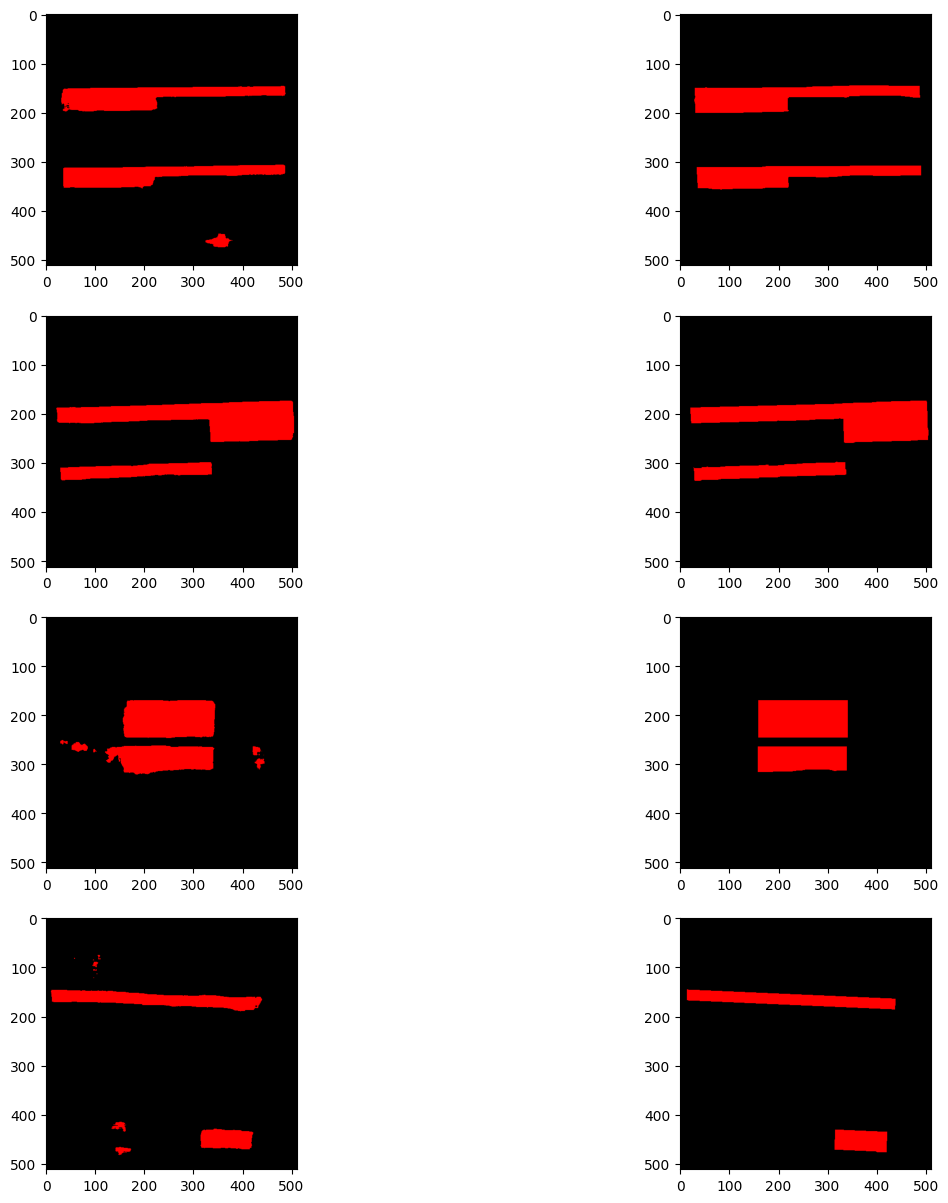

In [14]:



n_plots = 4
from matplotlib import pyplot as plt
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(n_plots):
    axarr[i,0].imshow(prediction_to_vis(predicted_mask[i,:,:]))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))

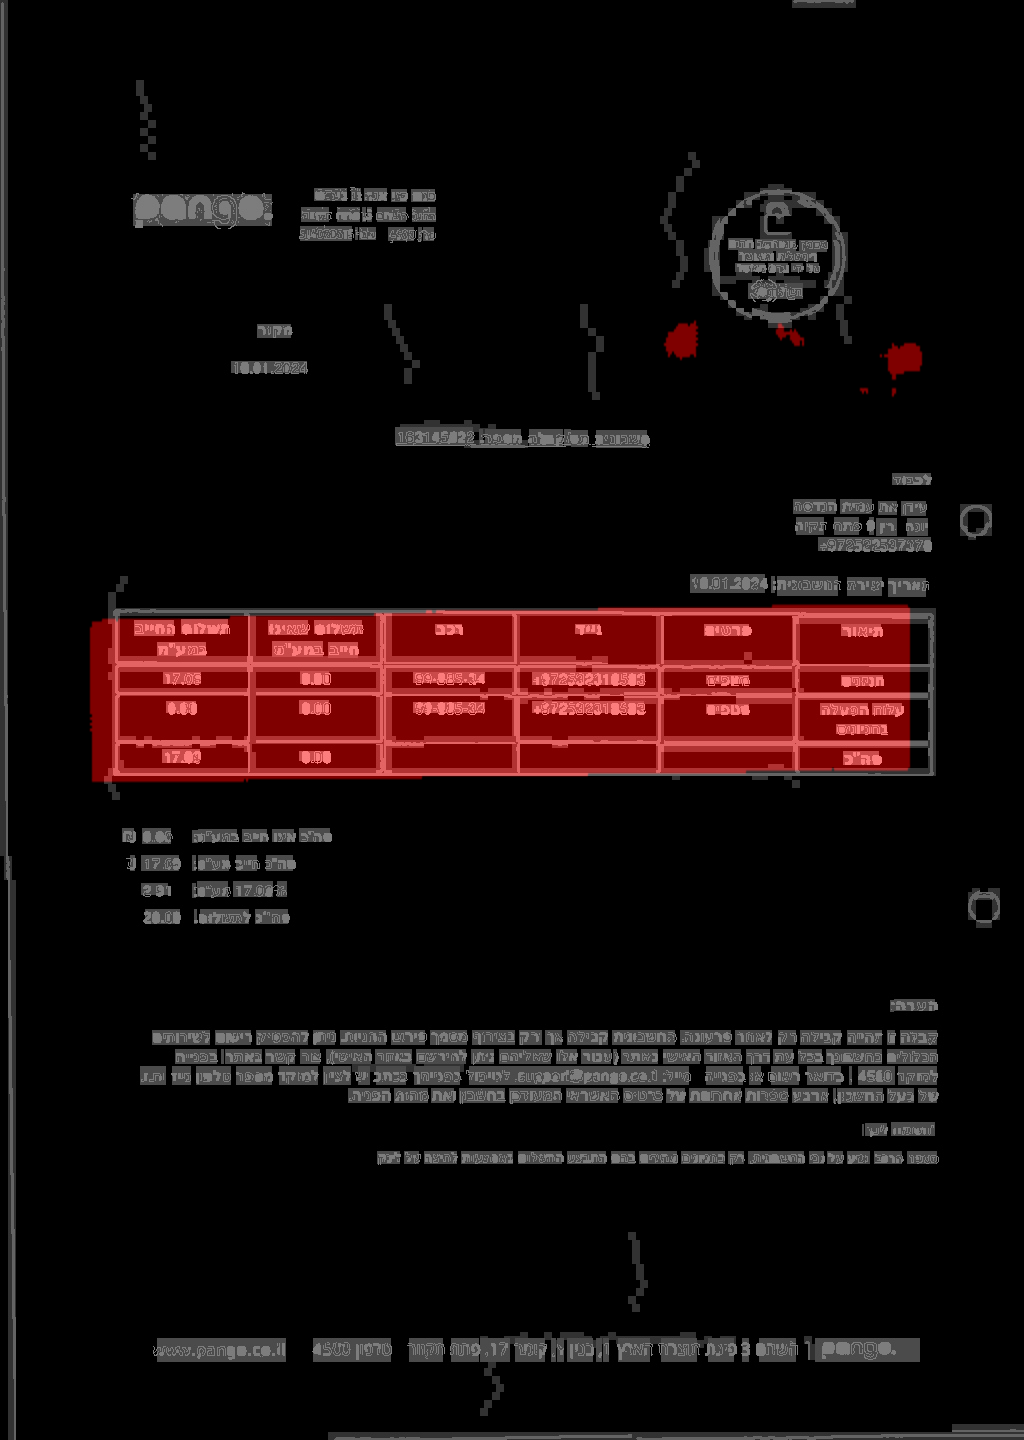

In [12]:
#Predict on a test image and overlay the mask on the original image
ds = train_ds
test_idx = 0
input_image_file = os.path.join(ds.root_dir,ds.images[test_idx])
input_image = Image.open(input_image_file)
test_batch = ds[test_idx]
images, masks = test_batch
images = torch.unsqueeze(images, 0)
masks = torch.unsqueeze(masks, 0)
images= images.to(DEVICE)
# outputs = model(images.half())
outputs = model(images)
preds = torch.sigmoid(outputs)
predicted_mask = (preds > 0.5).float()


mask = prediction_to_vis(predicted_mask[test_idx,:,:].cpu())
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)
overlay_img